In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# scipy.spatial.pdistを使うと様々な距離の距離行列を計算できます。デフォルトはユークリッド距離ですが、他にもいろいろ指定できる距離の種類があります。詳細はドキュメントを見てください。
from common.DensityRatio import kernelDensityRatio
# ここに密度比推定をするコードが書かれている

In [3]:
# データ設定
n, m = 100, 200
nu_mean, nu_sd = -0.5, 1
a_mean, a_sd = 1, 0.8
newdat = np.linspace(-4, 4, 500).reshape(500, 1) # 予測点
tnu = norm.pdf(newdat, nu_mean , nu_sd) #　確率密度の計算
tde = (norm.pdf(newdat, a_mean, a_sd) + tnu) / 2
tw = tnu/tde # 予測点上での真の密度比

In [4]:
# データ生成
nu = np.random.normal(nu_mean, nu_sd, size = n).reshape(n, 1)
# 0.5の確率で成功する試行をm回行なったときの成功数がmaに入れられる
ma = np.random.binomial(m,0.5);mb = m-ma
print(ma, m-ma)
de = np.r_[np.random.normal(nu_mean,
                           nu_sd, size = ma).reshape(ma, 1),
          np.random.normal(a_mean, a_sd, size = mb).reshape(mb, 1)]

98 102


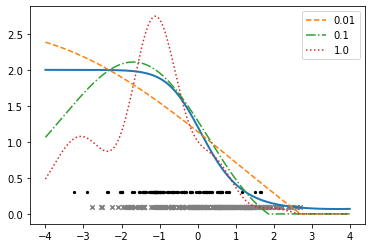

In [5]:
plt.plot(newdat, tw, lw = 2) # 真の密度比関数のプロット
# データ点のプロット
plt.scatter(nu.reshape(n, ), np.repeat(0.3, n), marker = '.', c = 'black', s = 20)
plt.scatter(de.reshape(m, ), np.repeat(0.1, m), marker = 'x', c = 'gray', s = 20)

# 以下のカーネル幅で推定
gammas = np.array([0.01, 0.1, 1])
lines = ['--', '-.', ':']
for i, g in enumerate(gammas):
    dr = kernelDensityRatio(gamma=g)
    dr.fit(de, nu) # データヘのフィッティング
    drp = dr.predict(newdat) # 密度比の予測値
    plt.plot(newdat, drp, linestyle=lines[i], label = g)
plt.legend();
plt.show();
    

In [6]:
# K重交差検証法による密度比のモデルパラメータ選択
from scipy.spatial import distance # distanceを使う
cvk = 5 # 交差検証のKは5
n, m = nu.shape[0], de.shape[0]

In [7]:
# カーネル幅パラメータの候補を生成
idx = np.random.choice(n+m, round((n+m)/2))
# np.percentileを利用している理由はminとmaxを利用すると外れ値の影響を受けたり、0の影響を受けたりするから
gammas = 1/np.percentile(distance.pdist(np.r_[nu, de][idx, :]),
                        [1, 99]) ** 2

In [8]:
print(min(distance.pdist(np.r_[nu, de][idx, :])), max(distance.pdist(np.r_[nu, de][idx, :])))
np.percentile(distance.pdist(np.r_[nu, de][idx, :]),
                        [1, 99])

0.0 5.580740738868126


array([0.0154604 , 4.34840585])

In [9]:
gammas = np.logspace(np.log10(gammas.min()/100),
                    np.log10(gammas.max()*100), 10)

In [10]:
# 正則化パラメータlambdaの候補を生成
lams = np.array([(min(n, m)) ** (-0.9)])
lams

array([0.01584893])

In [11]:
# モデルパラメータの候補
modelpars = np.array([(x, y) for x in gammas for y in lams ])

In [12]:
# それぞれのデータを5グループに分ける
inu = np.repeat(np.arange(cvk), np.ceil(n/cvk))
inu = inu[np.random.choice(n, n, replace = False)]
ide = np.repeat(np.arange(cvk), np.ceil(m/cvk))
ide = ide[np.random.choice(m, m, replace=False)]
cvloss = []
for gamma, lam in modelpars:
    tcvloss = []
    for k in np.arange(cvk):
        # トレーニングデータ
        trnu, trde = nu[inu != k, :], de[ide!=k, :]
        # テストデータ
        tenu, tede = nu[inu == k, :], de[ide == k, :]
        # 指定されたモデルパラメータで密度比を推定
        kdr = kernelDensityRatio(gamma=gamma, lam = lam)
        kdr.fit(trde, trnu)
        wde = kdr.predict(tede) # tede上で予測
        wnu = kdr.predict(tenu) # tenu上で予測
        tcvloss.append(np.mean(wde**2)/2 - np.mean(wnu))
    cvloss.append(np.mean(tcvloss))


In [13]:
# 最適なモデルパラメータ
print(modelpars)
optgamma, optlam = modelpars[np.argmin(cvloss), :]
optgamma, optlam

[[5.28858949e-04 1.58489319e-02]
 [5.15265250e-03 1.58489319e-02]
 [5.02020961e-02 1.58489319e-02]
 [4.89117101e-01 1.58489319e-02]
 [4.76544920e+00 1.58489319e-02]
 [4.64295892e+01 1.58489319e-02]
 [4.52361711e+02 1.58489319e-02]
 [4.40734284e+03 1.58489319e-02]
 [4.29405726e+04 1.58489319e-02]
 [4.18368356e+05 1.58489319e-02]]


(4.765449201263429, 0.015848931924611134)

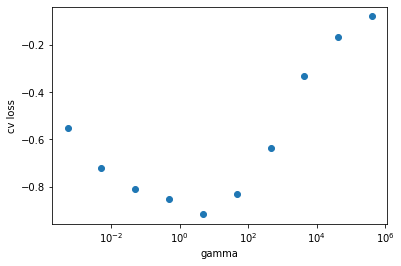

In [14]:
plt.xscale('log');plt.xlabel('gamma');plt.ylabel('cv loss')
plt.scatter(gammas, cvloss)
plt.show();

In [15]:
kdr = kernelDensityRatio(gamma = optgamma, lam = optlam)

In [16]:
kdr.fit(de, nu)
kdrp = kdr.predict(newdat)
kdrp.shape

(500,)

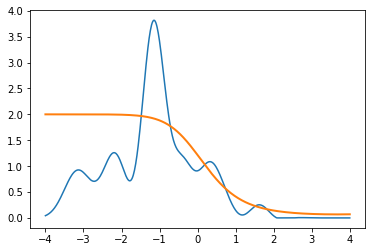

In [17]:
plt.plot(newdat, kdrp)
plt.plot(newdat, tw, lw = 2) # 真の密度比関数のプロット

In [18]:
# 真の回帰関数
def f(x):
    return ((x + 2) * (x - 3) * x)

In [19]:
# データ設定
ntr = 100; mtr = -1.4; sdtr = 0.7
nte = 100; mte = 0.8; sdte = 0.8

# トレーニングデータ生成
xtr = np.random.normal(mtr, sdtr, size = ntr).reshape(ntr, 1)
ytr = f(xtr) + np.random.normal(scale=2, size = ntr).reshape(ntr, 1)
# テストデータ生成
xte = np.random.normal(mte, sdte, size = nte).reshape(nte, 1)
yte = f(xte) + np.random.normal(scale=2, size = nte).reshape(nte, 1)

In [20]:
# トレーニングデータ点上での密度比を推定
kdr = kernelDensityRatio()
kdr.fit(xtr, xte)
pw = kdr.predict(xtr)

# 重み付き最小2乗法で回帰パラメータを推定
W = np.sqrt(np.diag(pw))
X = sm.add_constant(xtr)
WX = np.dot(W, X); WY = np.dot(W, ytr)
# これは最小二乗法の行列計算の基礎公式より！
estTheta = np.linalg.solve(np.dot(WX.T, WX), np.dot(WX.T, WY))
print(pw.shape,W.shape, X.shape, WX.shape, WY.shape, estTheta.shape)
print(estTheta)

(100,) (100, 100) (100, 2) (100, 2) (100, 1) (2, 1)
[[-0.67756402]
 [-3.3037433 ]]


In [28]:
from sklearn.preprocessing import scale
from sklearn import datasets

In [29]:
d = datasets.load_breast_cancer()

In [30]:
de = d.data[d.target == 0]; de = scale(de) # スケーリング
nu = d.data[d.target == 1]; nu = scale(nu) # スケーリング

In [31]:
kdr = kernelDensityRatio()
kdr.fit(de, nu) # 密度比推定

In [32]:
L1distEst = np.mean(abs(1 - kdr.predict(de))) # L1距離の推定値

In [33]:
nperm = 10000 # 並べ替え検定の繰り返し数
nde, nnu = de.shape[0], nu.shape[1]
dall = np.r_[de, nu]
permL1dist = []
for itr in np.arange(nperm):
    # データの並び替え
    idx = np.random.choice(nde + nnu, nde, replace = False)
    perm_de = dall[idx, :]
    perm_nu = np.delete(dall, idx, 0)
    pdr = kernelDensityRatio()
    # 並べ替え検定に対する密度比の推定
    pdr.fit(perm_de, perm_nu)
    # L1距離の推定
    permL1dist.append(np.mean(abs(1 - pdr.predict(perm_de))))

In [34]:
# 並べ替え検定によるp値
np.mean(L1distEst < np.array(permL1dist))

0.0294